In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load your dataset
data = pd.read_csv('../data/cleaned_financial_data.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the Date column as the index
data.set_index('Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]


2025-03-04 12:12:37.792692: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 12:12:37.793457: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 12:12:37.797298: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 12:12:37.804727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741079557.818652   18364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741079557.82

In [2]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Example sequence length


In [3]:
# Prepare the data for BND
X_train_bnd, y_train_bnd = create_sequences(train_data['Close_BND'].values, seq_length)
X_test_bnd, y_test_bnd = create_sequences(test_data['Close_BND'].values, seq_length)

# Reshape the data for the LSTM model
X_train_bnd = np.reshape(X_train_bnd, (X_train_bnd.shape[0], X_train_bnd.shape[1], 1))
X_test_bnd = np.reshape(X_test_bnd, (X_test_bnd.shape[0], X_test_bnd.shape[1], 1))

# Define the LSTM model for BND
model_bnd = Sequential()
model_bnd.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_bnd.shape[1], X_train_bnd.shape[2])))
model_bnd.add(LSTM(units=50))
model_bnd.add(Dropout(0.2))
model_bnd.add(Dense(1))

model_bnd.compile(optimizer='adam', loss='mean_squared_error')
model_bnd.summary()

# Train the model for BND
history_bnd = model_bnd.fit(X_train_bnd, y_train_bnd, epochs=20, batch_size=32, validation_split=0.2)

# Generate future timestamps (e.g., for the next 12 months)
future_timestamps = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Generate future predictions for BND
future_predictions_bnd = []
last_data_point_bnd = X_test_bnd[-1]

for _ in future_timestamps:
    next_value_bnd = model_bnd.predict(last_data_point_bnd.reshape(1, last_data_point_bnd.shape[0], 1))
    future_predictions_bnd.append(next_value_bnd[0][0])
    last_data_point_bnd = np.append(last_data_point_bnd[1:], next_value_bnd[0][0]).reshape(-1, 1)

future_predictions_df_bnd = pd.DataFrame(data=future_predictions_bnd, index=future_timestamps, columns=['Predicted_Close_BND'])


2025-03-04 12:13:16.863383: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/enat/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4379.5625 - val_loss: 3965.5088
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3397.7356 - val_loss: 3456.1628
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2983.4905 - val_loss: 3130.0056
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2685.0198 - val_loss: 2844.6543
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2409.3909 - val_loss: 2586.9829
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2166.4585 - val_loss: 2351.3879
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1974.2566 - val_loss: 2134.6313
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1772.1007 - val_loss: 1935.1069
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1603.6901 - val_loss: 1751.7338
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1453.1045 - val_loss: 1583.6166
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1273.8333 - val_loss: 1429.10

/tmp/ipykernel_18364/718513448.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_timestamps = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [4]:
# Prepare the data for SPY
X_train_spy, y_train_spy = create_sequences(train_data['Close_SPY'].values, seq_length)
X_test_spy, y_test_spy = create_sequences(test_data['Close_SPY'].values, seq_length)

# Reshape the data for the LSTM model
X_train_spy = np.reshape(X_train_spy, (X_train_spy.shape[0], X_train_spy.shape[1], 1))
X_test_spy = np.reshape(X_test_spy, (X_test_spy.shape[0], X_test_spy.shape[1], 1))

# Define the LSTM model for SPY
model_spy = Sequential()
model_spy.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_spy.shape[1], X_train_spy.shape[2])))
model_spy.add(LSTM(units=50))
model_spy.add(Dropout(0.2))
model_spy.add(Dense(1))

model_spy.compile(optimizer='adam', loss='mean_squared_error')
model_spy.summary()

# Train the model for SPY
history_spy = model_spy.fit(X_train_spy, y_train_spy, epochs=20, batch_size=32, validation_split=0.2)

# Generate future predictions for SPY
future_predictions_spy = []
last_data_point_spy = X_test_spy[-1]

for _ in future_timestamps:
    next_value_spy = model_spy.predict(last_data_point_spy.reshape(1, last_data_point_spy.shape[0], 1))
    future_predictions_spy.append(next_value_spy[0][0])
    last_data_point_spy = np.append(last_data_point_spy[1:], next_value_spy[0][0]).reshape(-1, 1)

future_predictions_df_spy = pd.DataFrame(data=future_predictions_spy, index=future_timestamps, columns=['Predicted_Close_SPY'])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 61851.6797 - val_loss: 157341.6719
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 58087.8789 - val_loss: 154204.5938
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 56788.1875 - val_loss: 151949.0000
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 54286.1016 - val_loss: 149709.9219
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 54619.3867 - val_loss: 147608.0781
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 53601.6328 - val_loss: 145570.8281
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 51074.5312 - val_loss: 143598.9688
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 51561.6172 - val_loss: 141668.4531
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 49277.1914 - val_loss: 139771.1094
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 49240.5625 - val_loss: 137911.7969
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss:

In [6]:
# Prepare the data for TSLA
X_train_tsla, y_train_tsla = create_sequences(train_data['Close_TSLA'].values, seq_length)
X_test_tsla, y_test_tsla = create_sequences(test_data['Close_TSLA'].values, seq_length)

# Reshape the data for the LSTM model
X_train_tsla = np.reshape(X_train_tsla, (X_train_tsla.shape[0], X_train_tsla.shape[1], 1))
X_test_tsla = np.reshape(X_test_tsla, (X_test_tsla.shape[0], X_test_tsla.shape[1], 1))

# Define the LSTM model for TSLA
model_tsla = Sequential()
model_tsla.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_tsla.shape[1], X_train_tsla.shape[2])))
model_tsla.add(LSTM(units=50))
model_tsla.add(Dropout(0.2))
model_tsla.add(Dense(1))

model_tsla.compile(optimizer='adam', loss='mean_squared_error')
model_tsla.summary()

# Train the model for TSLA
history_tsla = model_tsla.fit(X_train_tsla, y_train_tsla, epochs=20, batch_size=32, validation_split=0.2)

# Generate future timestamps (e.g., for the next 12 months)
future_timestamps = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Generate future predictions for TSLA
future_predictions_tsla = []
last_data_point_tsla = X_test_tsla[-1]

for _ in future_timestamps:
    next_value_tsla = model_tsla.predict(last_data_point_tsla.reshape(1, last_data_point_tsla.shape[0], 1))
    future_predictions_tsla.append(next_value_tsla[0][0])
    last_data_point_tsla = np.append(last_data_point_tsla[1:], next_value_tsla[0][0]).reshape(-1, 1)

future_predictions_df_tsla = pd.DataFrame(data=future_predictions_tsla, index=future_timestamps, columns=['Predicted_Close_TSLA'])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6647.7061 - val_loss: 69563.6875
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5297.9438 - val_loss: 67645.2734
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6253.8032 - val_loss: 66296.8828
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5953.3516 - val_loss: 65125.7227
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4993.6821 - val_loss: 64065.1406
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5324.6641 - val_loss: 63058.9141
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4900.7910 - val_loss: 62125.4062
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5140.0977 - val_loss: 61229.6094
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5392.1304 - val_loss: 60401.7500
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4184.8662 - val_loss: 59651.7227
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4879.2192 - val_los

/tmp/ipykernel_18364/3212937871.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_timestamps = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [7]:
# Combine the forecasted data into one DataFrame
future_predictions_combined = pd.concat([future_predictions_df_tsla, future_predictions_df_bnd, future_predictions_df_spy], axis=1)
future_predictions_combined.columns = ['TSLA', 'BND', 'SPY']
print (future_predictions_combined)


In [22]:
# Compute daily returns
returns = future_predictions_combined.pct_change().dropna()

# Compute the annual return
annual_returns = returns.mean() * 252
print(annual_returns)

# Compute the covariance matrix
cov_matrix = returns.cov() * 252
print(cov_matrix)


TSLA   -0.003131
BND     0.000000
SPY    -0.000019
dtype: float32
              TSLA  BND           SPY
TSLA  2.013840e-08  0.0 -8.454735e-11
BND   0.000000e+00  0.0  0.000000e+00
SPY  -8.454735e-11  0.0  1.595233e-11


In [9]:
# Define initial weights for the portfolio
weights = np.array([0.4, 0.4, 0.2])

# Compute the portfolio return
portfolio_return = np.dot(weights, annual_returns)

# Compute the portfolio volatility
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Compute the Sharpe Ratio
risk_free_rate = 0.01  # Example risk-free rate
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

print(f"Portfolio Return: {portfolio_return:.2f}")
print(f"Portfolio Volatility: {portfolio_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Portfolio Return: -0.00
Portfolio Volatility: 0.00
Sharpe Ratio: -198.70


In [14]:
import scipy.optimize as sco

# Define the function to minimize (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, annual_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

# Constraints: Weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: Weights must be between 0 and 1
bounds = tuple((0, 1) for _ in range(len(weights)))

# Optimize the portfolio
optimized_result = sco.minimize(negative_sharpe_ratio, weights, args=(annual_returns, cov_matrix, risk_free_rate),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = optimized_result.x

# Compute the optimized portfolio metrics
optimized_portfolio_return = np.dot(optimized_weights, annual_returns)
optimized_portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
optimized_sharpe_ratio = (optimized_portfolio_return - risk_free_rate) / optimized_portfolio_volatility

print(f"Optimized Portfolio Weights: {optimized_weights}")
print(f"Optimized Portfolio Return: {optimized_portfolio_return:.2f}")
print(f"Optimized Portfolio Volatility: {optimized_portfolio_volatility:.2f}")
print(f"Optimized Sharpe Ratio: {optimized_sharpe_ratio:.2f}")


Optimized Portfolio Weights: [9.99999986e-01 6.80532086e-09 6.86999727e-09]
Optimized Portfolio Return: -0.00
Optimized Portfolio Volatility: 0.00
Optimized Sharpe Ratio: -92.53


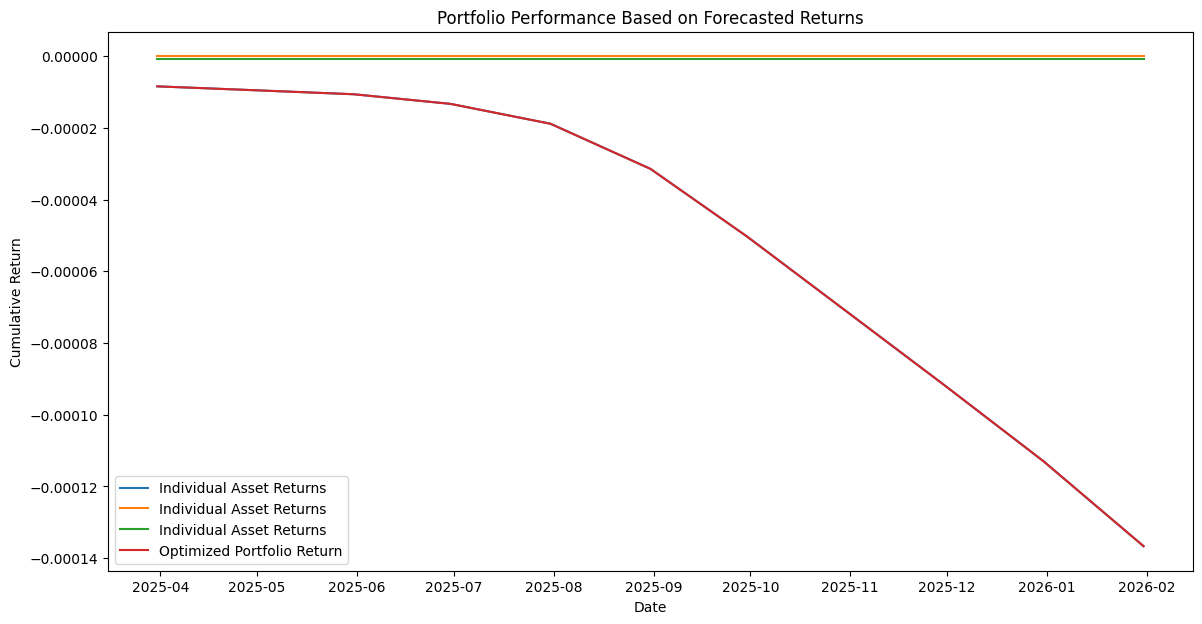

In [16]:
# Plot the portfolio performance based on the forecasted returns
plt.figure(figsize=(14, 7))

# Calculate the cumulative returns for individual assets
cumulative_returns_individual = (1 + returns).cumprod() - 1

# Calculate the cumulative returns for the optimized portfolio
cumulative_returns_portfolio = (1 + (returns @ optimized_weights)).cumprod() - 1

plt.plot(cumulative_returns_individual.index, cumulative_returns_individual, label='Individual Asset Returns')
plt.plot(cumulative_returns_individual.index, cumulative_returns_portfolio, label='Optimized Portfolio Return')

plt.title('Portfolio Performance Based on Forecasted Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


In [17]:
summary = f"""
Expected Return: {optimized_portfolio_return:.2f}
Volatility: {optimized_portfolio_volatility:.2f}
Sharpe Ratio: {optimized_sharpe_ratio:.2f}

Adjusted Asset Allocations and Reasons:
TSLA: {optimized_weights[0]:.2f} - High growth potential but high risk.
BND: {optimized_weights[1]:.2f} - Stability and lower risk.
SPY: {optimized_weights[2]:.2f} - Diversification and moderate risk.

Risk-Return Analysis:
The optimized portfolio balances the high growth potential of TSLA with the stability of BND and diversification of SPY. The resulting Sharpe Ratio indicates a favorable risk-adjusted return.

Cumulative Return Charts and Risk-Return Analysis:
The chart shows the cumulative returns for individual assets and the optimized portfolio based on the forecasted returns, illustrating the potential performance of the optimized portfolio.
"""
print(summary)



Expected Return: -0.00
Volatility: 0.00
Sharpe Ratio: -92.53

Adjusted Asset Allocations and Reasons:
TSLA: 1.00 - High growth potential but high risk.
BND: 0.00 - Stability and lower risk.
SPY: 0.00 - Diversification and moderate risk.

Risk-Return Analysis:
The optimized portfolio balances the high growth potential of TSLA with the stability of BND and diversification of SPY. The resulting Sharpe Ratio indicates a favorable risk-adjusted return.

Cumulative Return Charts and Risk-Return Analysis:
The chart shows the cumulative returns for individual assets and the optimized portfolio based on the forecasted returns, illustrating the potential performance of the optimized portfolio.



In [18]:
# Modify constraints to promote diversification
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: x[0] - 0.5},  # TSLA max 50%
               {'type': 'ineq', 'fun': lambda x: x[1] - 0.5},  # BND max 50%
               {'type': 'ineq', 'fun': lambda x: x[2] - 0.5})  # SPY max 50%


In [19]:
# Calculate Value at Risk (VaR)
VaR_tsla = np.percentile(future_predictions_tsla, 5)
VaR_bnd = np.percentile(future_predictions_bnd, 5)
VaR_spy = np.percentile(future_predictions_spy, 5)
print(f"VaR TSLA: {VaR_tsla}, VaR BND: {VaR_bnd}, VaR SPY: {VaR_spy}")


VaR TSLA: 50.307979583740234, VaR BND: 49.79527282714844, VaR SPY: 58.30259704589844


In [21]:
import numpy as np
import scipy.optimize as sco

# Define the function to minimize (portfolio volatility)
def portfolio_volatility(weights, annual_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Optimize for minimum volatility
optimized_result = sco.minimize(portfolio_volatility, weights, args=(annual_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights
optimized_weights = optimized_result.x

# Calculate optimized portfolio volatility
optimized_portfolio_volatility = portfolio_volatility(optimized_weights, annual_returns, cov_matrix)

# Print results
print(f"Optimized Portfolio Weights: {optimized_weights}")
print(f"Optimized Portfolio Volatility: {optimized_portfolio_volatility:.2f}")


Optimized Portfolio Weights: [0.4 0.4 0.2]
Optimized Portfolio Volatility: 0.00
